Importando as bibliotecas:

In [1]:
import os
import pathlib
import time
import codecs
import string
import re
import pickle
from functools import reduce
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import urllib
import requests
from bs4 import BeautifulSoup

import nltk
import networkx as nx
import gensim
from wordcloud import WordCloud

# https://stackoverflow.com/questions/50743723/cant-install-textract-on-windows?noredirect=1&lq=1 
# https://github.com/deanmalmgren/textract/issues/190
#https://my.visualstudio.com/Downloads?pid=2082
import textract

from IPython.core.display import Image
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Lendo o arquivo:

In [2]:
df = pd.read_csv('./mediaframe_export.csv')

Examinando as primeiras linhas:

In [3]:
df.head()

,id,website,url,publication_date,title,text
0,1215050,Estadão,"http://opiniao.estadao.com.br/noticias/geral,b...",2016-05-29T06:06:00,Blogueiros chapa branca,Escrita com o objetivo de denunciar o “golpe p...
1,1242971,Estadão,"http://opiniao.estadao.com.br/noticias/geral,m...",2016-02-15T06:06:00,Mito derretendo,Os defeitos pessoais e as limitações humanas d...
2,1219263,Estadão,"http://opiniao.estadao.com.br/noticias/geral,f...",2016-05-13T06:06:00,Fórum dos Leitores,"Vitória do povo brasileiro\n\nFinalmente, após..."
3,1267524,Estadão,"http://opiniao.estadao.com.br/noticias/geral,f...",2015-10-28T05:34:00,Fórum dos leitores,Politiquices\n\nRelato três casos publicados n...
4,1295171,Estadão,"http://opiniao.estadao.com.br/noticias/geral,f...",2015-07-06T06:06:00,Fórum dos leitores,Conversa com o povo\n\nO ex-presidente Lulla s...


Exportando para um arquivo de texto:

In [11]:
import codecs
with codecs.open('./mediaframe_export.txt', 'w', "utf-8") as f:
    for entry in df.index:
        f.write('\n\n---------{}----------\n'.format(df.loc[entry, 'publication_date']))
        f.write('{}\n\n'.format(df.loc[entry, 'url']))
        f.write(df.loc[entry, 'text'])
        

Exportando para o Excel (alguns campos excedem ao máximo de número de caracteres em uma célula)

In [ ]:
#df.to_excel('./mediaframe_export.xls')

Transformando o campo "publication_date" em um campo do tipo datetime:

In [4]:
df['publication_date'] = pd.to_datetime(df['publication_date'])

Transformando o campo "publication time" em índice:

In [5]:
df.set_index('publication_date', inplace=True)
df.sort_index(inplace=True)

Examinando o tipo de dado das entradas:

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1339 entries, 2009-03-21 03:06:00 to 2019-01-08 08:06:00
Data columns (total 5 columns):
id         1339 non-null int64
website    1339 non-null object
url        1339 non-null object
title      1339 non-null object
text       1339 non-null object
dtypes: int64(1), object(4)
memory usage: 62.8+ KB


(pode-se ver que agora o intervalo de tempo é explícito, como um índice do dataframe)

Examinando a quantidade de textos dentro de um intervalo específico:

In [7]:
len(df.loc['2017-01-01':'2017-01-10'].text)

2

Examinando os textos de um intervalo de tempo específico:

In [8]:
for texto in df.loc['2017-01-01':'2017-01-10'].text:
    print(texto)

Apesar de ter registrado em 2016 o mesmo desempenho medíocre dos anos anteriores, a ponto de ficar na 63.ª posição em ciências e no 66.º lugar em matemática no ranking de 70 países da última edição do Programa Internacional de Avaliação de Estudantes (Pisa), com a substituição da presidente Dilma Rousseff pelo presidente Michel Temer o sistema brasileiro de ensino sofreu uma mudança de gestão. Só o desmonte da hegemonia ideológica e dos interesses corporativos que vinham norteando a atuação do Ministério da Educação (MEC) pode ser suficiente para reverter a crise em que o setor se encontra.

Acima de tudo, os novos dirigentes do MEC voltaram a falar em prioridades, o que não ocorria desde a ascensão do PT ao poder, em 2003. Em seus treze anos e meio de governo, o lulopetismo tomou iniciativas a esmo na área educacional. Lançou cerca de 40 programas sem coerência, sem pertinência e sem controles, esquecendo-se de que, quando não há avaliação nem definição de metas, não há resultados, ma

Examinando a quantidade de textos ao longo de uma unidade de tempo (por dia, semana, mês, ano...):

In [9]:
#df.text.resample('D').count()
#df.text.resample('W').count()
#df.text.resample('M').count()
df.text.resample('Y').count()

publication_date
2009-12-31      3
2010-12-31      3
2011-12-31     63
2012-12-31     90
2013-12-31     80
2014-12-31    135
2015-12-31    270
2016-12-31    359
2017-12-31    156
2018-12-31    175
2019-12-31      5
Freq: A-DEC, Name: text, dtype: int64

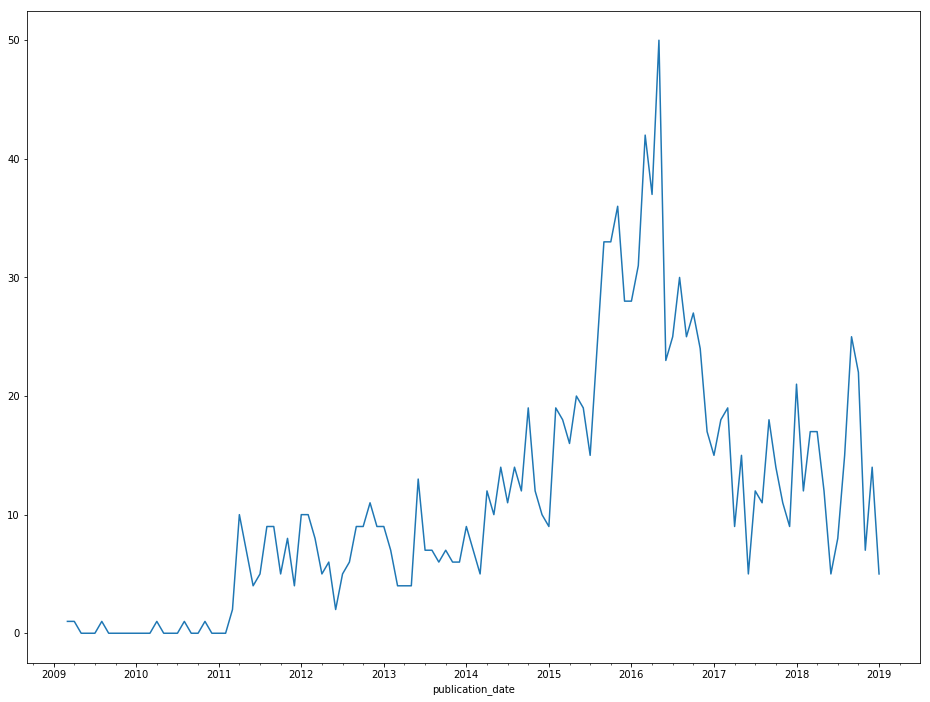

In [10]:
fig, ax = plt.subplots(figsize=(16, 12))
#df.text.resample('D').count().plot()
#df.text.resample('W').count().plot()
df.text.resample('M').count().plot()
#df.text.resample('Y').count().plot()

Examinando ocorrências em todos os textos somados:

In [11]:
texts = reduce(lambda x,y: str(x)+str(y), df.text.values)
#df['text'] = df['text'].map(lambda x: str(x) + ' ')
#texts = df['text'].sum()

In [15]:
texts[0:1000]

'Irresponsabilidade sem limites\n\nÉ inescapável a responsabilidade do governo e especialmente do presidente Lula na crise que assola nossa economia. É evidente que ela começou lá fora, em especial nos Estados Unidos, estendeu-se aos demais países desenvolvidos e atinge hoje todo o mundo. Mas o Brasil poderia estar infinitamente melhor e mais preparado para enfrentá-la se tivéssemos um governo lúcido e um estadista na Presidência disposto a assumir a sua responsabilidade histórica. Em artigos anteriores, neste mesmo espaço, já analisei por que a crise chegou aqui antes e mais intensa do que o esperado, por culpa do governo. Falei do câmbio, da precariedade da situação fiscal e da insegurança transmitida ao mercado pelo discurso e pelas atitudes contraditórias das autoridades. O primeiro elo da cadeia de transmissão da crise no Brasil foi o câmbio, que deixou o real inacreditavelmente supervalorizado durante vários anos. A responsabilidade do Banco Central nesse particular é evidente. E

In [13]:
with open('./texts.pkl', 'wb') as f:
    pickle.dump(texts, f)

In [14]:
with open('./texts.pkl', 'rb') as f:
    texts = pickle.load(f)

In [16]:
stop_pt = nltk.corpus.stopwords.words('portuguese')
stop_en = nltk.corpus.stopwords.words('english')
stopwords = stop_en + stop_pt
stopwords.extend(['-',''])

In [20]:
list_words = texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation) for l in list_words]
list_words_clean = [l for l in list_words if l not in stopwords]

text_complete = ' '.join(list_words)
text_cleaned = ' '.join(list_words_clean)

In [21]:
freqdist = Counter(list_words_clean)
freqdist.most_common(30)

[('é', 44524),
 ('paulo', 28006),
 ('brasil', 13800),
 ('governo', 13023),
 ('país', 12820),
 ('ser', 12195),
 ('lula', 11980),
 ('dilma', 11543),
 ('presidente', 10943),
 ('pt', 9593),
 ('todos', 6953),
 ('anos', 6910),
 ('ainda', 6839),
 ('agora', 6088),
 ('sobre', 6087),
 ('josé', 5811),
 ('povo', 5797),
 ('federal', 5761),
 ('ter', 5548),
 ('–', 5546),
 ('poder', 5527),
 ('vai', 5433),
 ('bem', 5369),
 ('política', 5366),
 ('contra', 5358),
 ('ministro', 5342),
 ('tudo', 5106),
 ('corrupção', 5021),
 ('estado', 4985),
 ('pode', 4905)]

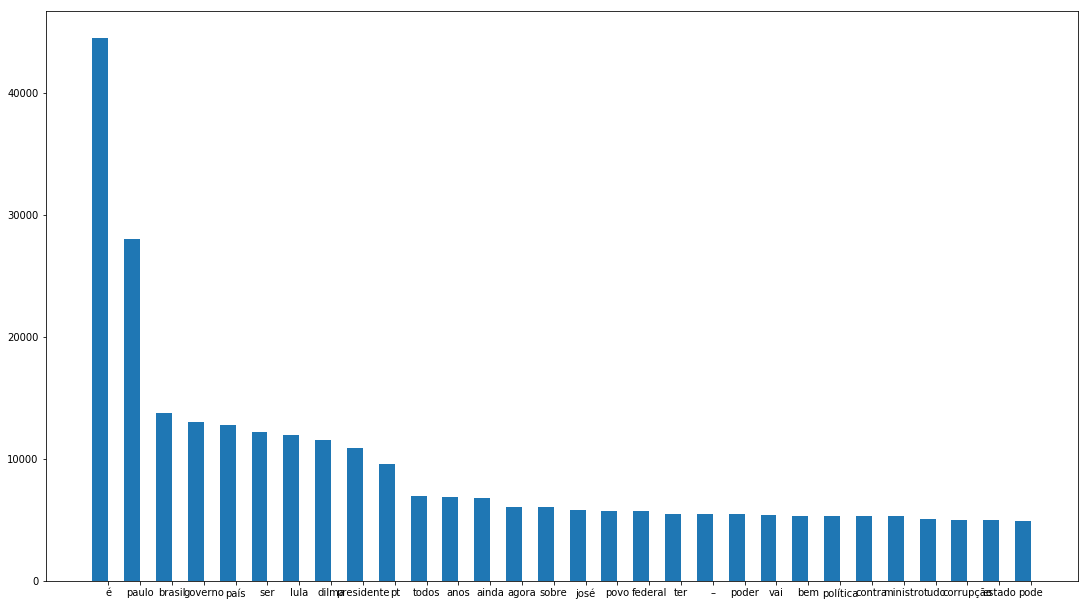

In [57]:
labels, values = zip(*freqdist.most_common(30))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

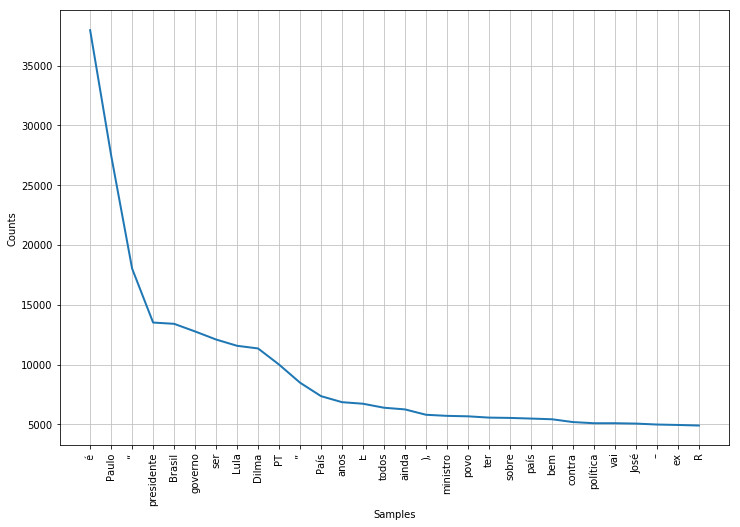

In [68]:
fd_words = nltk.FreqDist([token for token in tokens if token.lower() not in stopwords \
                          and token not in string.punctuation \
                          and token not in ['"', ')', '(', 'gmail', 'hotmail', 'uol', 'br']])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

In [28]:
expression = 'lulopetismo'

In [29]:
freqdist[expression]

1752

In [35]:
pos = 0 
positions = []
while pos != -1:
    position = text_complete.find(expression,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print('The expression is found {} times'.format(len(positions)))

The expression is found 1806 times


In [39]:
window = 50
for position in positions[0:100]:
    print(text_complete[position - window:position + window + len(expression)].strip())

ores públicos uma espécie de eleitorado cativo do lulopetismo não tenham dúvidas o lobby dos funcionários falar
ros e a intervir na economia o uso político que o lulopetismo faz da petrobrás e agora do banco do brasil bb é
sarney collor e renan sustentando politicamente o lulopetismo de resultados ou seja a mais nova versão da manja
o olhar para trás na direção de seu passado mas o lulopetismo encontra-se numa categoria separada a narrativa h
vii a peregrinação de dilma à canossa tropical do lulopetismo equivale à adição de um novo capítulo na versão c
e que estão sendo desrespeitadas pelo governo do lulopetismo gostariam muito de saber paulo boccato pofboccato
a ao longo dos últimos oito anos pelo fenômeno do lulopetismo torrente verbal de linguajar chulo e de eterno pa
m bom governo será candidata à reeleição se não o lulopetismo deverá ter lula de volta em 2014 ou 2018 como fal
depois de praticamente quebrar a petobrais sic o lulopetismo quer agora aparelhar o maior orgulho brasilei

In [41]:
# Using NLTK and maintaining punctuation
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(texts)
nltk_text = nltk.Text(tokens)
nltk_text.concordance(expression.lower(), width=120, lines=50)

Displaying 50 of 1792 matches:
es públicos , uma espécie de " eleitorado cativo " do lulopetismo . Não tenham dúvidas : o lobby dos funcionários falar
eiros e a intervir na economia . O uso político que o lulopetismo faz da Petrobrás e agora do Banco do Brasil ( BB ) é 
Sarney , Collor e Renan sustentando politicamente o " lulopetismo de resultados ", ou seja , a mais nova versão da manj
o olhar para trás , na direção de seu passado . Mas o lulopetismo encontra - se numa categoria separada . A narrativa h
o VII . A peregrinação de Dilma à Canossa tropical do lulopetismo equivale à adição de um novo capítulo na versão conti
es , e que estão sendo desrespeitadas pelo governo do lulopetismo , gostariam muito de saber ... Paulo Boccato pofbocca
a , ao longo dos últimos oito anos , pelo fenômeno do lulopetismo . Torrente verbal de linguajar chulo e de eterno pala
m bom governo será candidata à reeleição . Se não , o lulopetismo deverá ter Lula de volta em 2014 ( ou 2018 ). Como fa
ois de pr

Palavras que ocorrem frequentemente juntas

In [45]:
nltk_text.collocations(num=100, window_size=2)

São Paulo; com São; Lava Jato; Dilma Rousseff; Supremo Tribunal;
Michel Temer; Operação Lava; Tribunal Federal; Polícia Federal;
presidente Dilma; Ministério Público; povo brasileiro; que não; Renan
Calheiros; Eduardo Cunha; Será que; Aécio Neves; Congresso Nacional;
Belo Horizonte; Fernando Haddad; uma vez; com Rio; Panossian
paulopanossian; Decol decoljs; José Dirceu; Gilmar Mendes; Sérgio
Moro; nosso país; governo federal; Cartas selecionadas; não tem; cada
vez; Frid luiz; Estados Unidos; Monte Santo; Geraldo Alckmin; dinheiro
público; Beatriz Campos; portal estadao; Tonelli angelotonelli; Izabel
Avallone; Campos beatriz; Angelo Tonelli; pode ser; foro privilegiado;
dos Deputados; Avallone izabelavallone; que que; ter sido; Panayotis
Poulis; Jair Bolsonaro; SÃO PAULO; deve ser; Rio Claro; cofres
públicos; delação premiada; dona Dilma; deste país; Forças Armadas;
Dias Toffoli; Fernando Henrique; Poulis ppoulis46; Coelho jairgcoelho;
nos últimos; Joaquim Levy; Fernandes standyball; Ri

In [46]:
nltk_text.collocations(num=100, window_size=3)

São Paulo; gmail com; uol com; com São; Rio Janeiro; hotmail com; Lava
Jato; com Paulo; Dilma Rousseff; yahoo com; Supremo Tribunal; Michel
Temer; Tribunal Federal; Operação Lava; terra com; Supremo Federal;
Operação Jato; Polícia Federal; presidente Dilma; Ministério Público;
povo brasileiro; Renan Calheiros; que não; Eduardo Cunha; Câmara
Deputados; Fórum Leitores; Aécio Neves; Congresso Nacional; juiz Moro;
Fernando Haddad; Federal STF; frid globomail; Belo Horizonte; globo
com; luiz frid; beatriz campos; Bernardo Campo; uma vez; Panossian
paulopanossian; Sérgio Moro; Decol decoljs; José Dirceu; Gilmar
Mendes; nosso país; Será que; Beatriz beatriz; Monte Santo; cada vez;
que que; Geraldo Alckmin; presidente República; Cartas selecionadas;
governo federal; Frid luiz; Estados Unidos; bol com; Leitores portal;
Presidência República; dinheiro público; Beatriz Campos; com Rio;
portal estadao; Campos beatriz; Santo Minas; pode ser; Tonelli
angelotonelli; Lula Silva; foro privilegiado; Iza

Palavras que ocorrem frequentemente próximas a uma expressao especifica

In [44]:
nltk_text.similar(expression)

pt brasil governo país que povo stf estado poder mundo partido lula
mensalão congresso psdb estadão impeachment ministro senado judiciário


Bigramas frequentes (utilizando várias medidas)

In [69]:
#Pointwise Mutual Information.

max_items = 50
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

Caramello Uliano
Produtos Industrializados
HELEO POHLMANN
Kaled Baruche
LAZAR KRYM
Mani Pulite
OLINTO OLIVOTTO
Sagrado Lamir
Toshio Icizuca
Agrella antoniodagrella
Arsonval Mazzucco
METNE ARNAUT
Turssi turssi
Uliano scaramellu
Baruche kbaruche
CLODER RIVAS
HERMANN MONDL
OTTO ORTLEPP
Piccioni piccionijl
RIVAS MARTOS
Treffis jotatreffis
ULF HERMANN
Canato jccanato
Condomi Alcorta
Sueli Caramello
BLACK BLOCS
capitanias hereditárias
Habib Saguiah
Leonidas Ronconi
Olinto Olivotto
Andreazzi orelio
Arturo Condomi
Baruk alicebaruk
OTTFRIED KELBERT
Gândara clineurohenrique
HELVIO MIOTTO
Natali apollo
Pavani roger
Rathsam mariusrathsam
Ronconi ronconileonidas
Sri Lanka
Tude petude
Big Brother
Cassapula waldir
Marieta Barugo
Rieder rieder
FEBRE AMARELA
Rômulo Bini
CESARE BATTISTI
Demétrio Magnoli


In [49]:
# contagem simples

for a, b in (finder2.above_score(bigram_measures.raw_freq, 1000.0 / len(list(nltk.bigrams(tokens))))):
        print(a, b)

São Paulo
que o
br São
com São
que a
o que
com a
que não
para o
com o
e a
e o
de que
que se
para a
de um
o Brasil
que os
do PT
de uma
é o
do que
o governo
todos os
em que
não é
Rio de
de Janeiro
e não
do governo
o País
Dilma Rousseff
o PT
do Brasil
e de
é a
que é
no Brasil
de São
da República
não se
Lava Jato
e que
do País
é que
o povo
para que
de Lula
presidente Dilma
mais de
com os
é um
a presidente
presidente da
O que
falta de
para os
e os
de R
e do
de Dilma
e da
que está
com Rio
não tem
o seu
que ele
é uma
a sua
que as
milhões de
de ser
como o
de sua
do Estado
Será que
de seu
de seus
sobre a
sobre o
todas as
o ministro
do povo
presidente do
da Petrobrás
do STF
por que
Supremo Tribunal
o presidente
contra a
Tribunal Federal
com as
Lula e
o ex
Michel Temer
povo brasileiro
da Silva
contra o
da presidente
ministro da
uma vez
Operação Lava
se o
que foi
a corrupção
a ser
é de
além de
anos de
Polícia Federal
mais uma
como se
todo o
de corrupção
como a
se a
que já
da Justiça
e com
O Brasil

Trigramas

In [70]:
max_items = 50
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

ELISABETE DARIM PARISOTTO
Filip Riwczes filipriw
Elisabete Darim Parisotto
Michelle Schott mschott
ARTURO CONDOMI ALCORTA
DARIM PARISOTTO beteparisotto
Ferdinando Perrella fperrella
BENFATTI RESSTEL sbresstel
ARI GIORGI arigiorgi
Faruk Hamza botafogorio
Jürgen Detlev Vageler
Dionysio Vecchiatti dio
CLÊNIO FALCÃO LINS
Darim Parisotto beteparisotto
Odair Picciolli odairpicciolli
LINS CALDAS clenio
MINORU TAKAHASHI minorinhotakahashi
Simonsen Nico mentanico
Mema Bernaba jorgebernaba
Pinotti Borguetti epborguetti
Benfatti Resstel sbresstel
Detlev Vageler vatra_ind
FALCÃO LINS CALDAS
MILAN TRSIC cra612
Jan Krotoszynski jankroto
Eleonora Samara eleonorsamara
Caramello Uliano scaramellu
Hans Dieter Grandberg
NELIO ESQUERDO nelioesquerdo
Lauro Fujihara laurofujihara
Sueli Caramello Uliano
FONTOURA LEINZ fredy1943
Iracema Palombello cepalombello
Orélio Andreazzi orelio
Edward Brunieri patricia
Battesini Ramalho leticialivros
Kaled Baruche kbaruche
ULF HERMANN MONDL
Sara May sara
Eraldo Bartolom

In [51]:
for a, b, c in finder3.above_score(trigram_measures.raw_freq,100.0 / len(list(nltk.trigrams(tokens)))):
        print (a, b, c)

br São Paulo
com São Paulo
Rio de Janeiro
com Rio de
Supremo Tribunal Federal
Operação Lava Jato
presidente da República
a presidente Dilma
que o Brasil
em São Paulo
Lula da Silva
presidente Dilma Rousseff
do Supremo Tribunal
que o governo
que o PT
mais do que
Câmara dos Deputados
tudo o que
Presidência da República
cada vez mais
em que o
mais uma vez
br Rio de
o povo brasileiro
com São Carlos
o que é
“ Estadão ”
do Rio de
Fórum dos Leitores
que não se
São Bernardo do
Bernardo do Campo
que o País
Monte Santo de
Santo de Minas
do povo brasileiro
para o Brasil
Paulo Panossian paulopanossian
em todos os
presidente da Câmara
São Caetano do
a falta de
selecionadas para o
Caetano do Sul
Beatriz Campos beatriz
ministro da Justiça
br Rio Claro
Palácio do Planalto
que o povo
dos Leitores do
o Fórum dos
Leitores do portal
presidente Michel Temer
em que se
para o Fórum
Cartas selecionadas para
a Polícia Federal
para que o
Lula e Dilma
do portal estadao
ministro da Fazenda
o fato de
o que se
por m

Ao longo do corpus, como algumas palavras ocorrem:

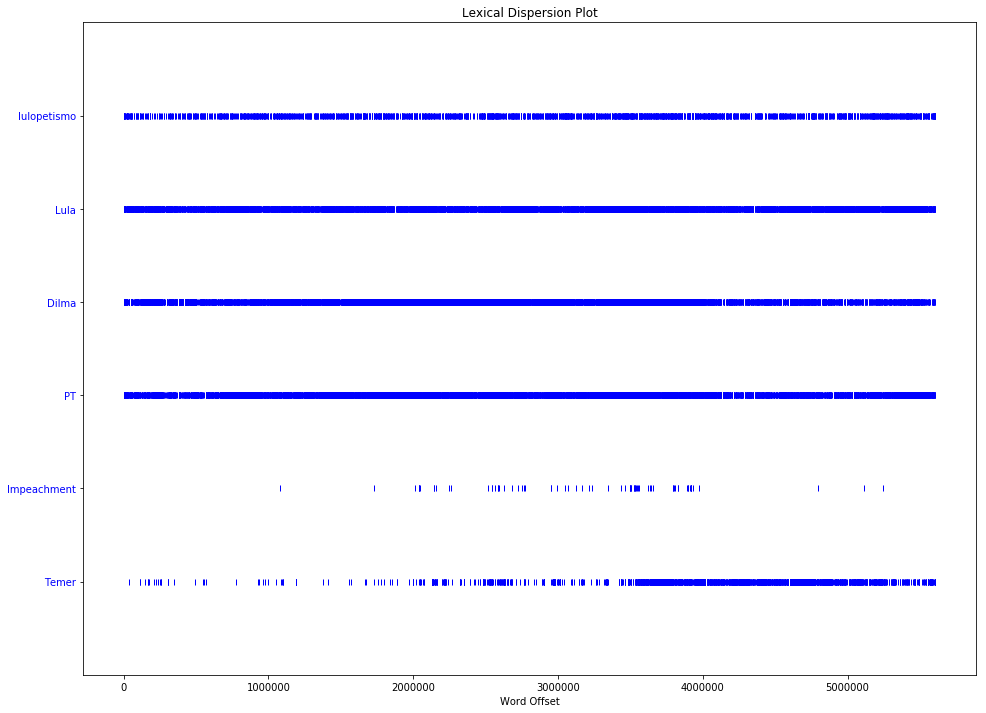

In [56]:
fig, ax = plt.subplots(figsize=(16, 12))
dispersion_words = ['lulopetismo', 'Lula', 'Dilma', 'PT', 'Impeachment', 'Temer']
nltk_text.dispersion_plot(dispersion_words)

Wordclouds

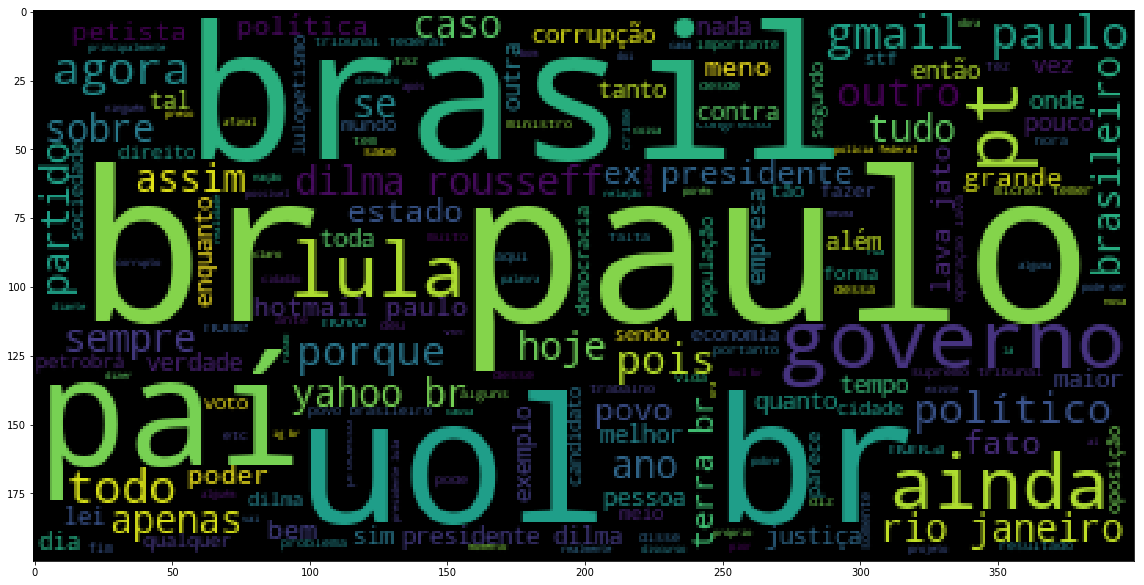

In [24]:
wordcloud = WordCloud().generate(text_cleaned)
fig, ax = plt.subplots(figsize=(16, 16))
ax.imshow(wordcloud, interpolation='nearest')
plt.tight_layout()

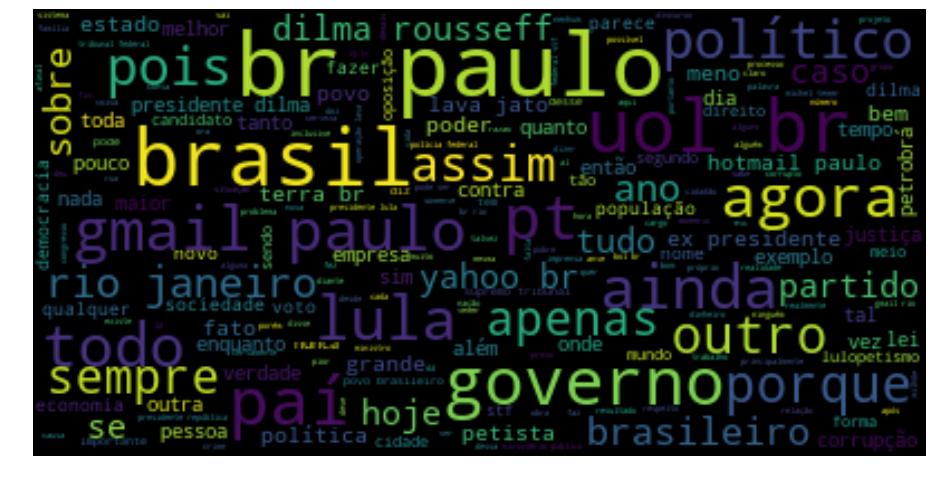

In [25]:
# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text_cleaned)
plt.figure(figsize=(16, 16))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()